In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import re
import urllib.request

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7f803edb7810>)

In [3]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [4]:
print('훈련용 리뷰 개수 :', len(train_data))
print('테스트용 리뷰 개수 :', len(test_data))

훈련용 리뷰 개수 : 150000
테스트용 리뷰 개수 : 50000


In [5]:
train_data['document'].nunique(), train_data['label'].nunique()

(146182, 2)

In [6]:
# 중복제거
train_data.drop_duplicates(subset=['document'], inplace=True)

In [7]:
print('총 샘플의 수 :', len(train_data))

총 샘플의 수 : 146183


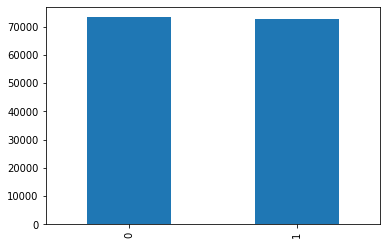

In [8]:
train_data['label'].value_counts().plot(kind='bar')

In [9]:
print(train_data.groupby('label').size().reset_index(name='count'))

   label  count
0      0  73342
1      1  72841


In [10]:
train_data.isnull().sum()

id          0
document    1
label       0
dtype: int64

In [22]:
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣]", "")
train_data['document'] = train_data['document'].str.replace('^ +', "")
train_data['document'].replace('',np.nan, inplace=True)

test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣]", "")
test_data['document'] = test_data['document'].str.replace('^ +', "")
test_data['document'].replace('',np.nan, inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [23]:
# nan값 제거
train_data = train_data.dropna()
test_data = test_data.dropna()

In [24]:
train_data.isnull().sum()
test_data.isnull().sum()

id          0
document    0
label       0
dtype: int64

## 토크나이저를 이용한 정수 인코딩

In [25]:
!pip install transformers

In [26]:
import transformers

In [27]:
transformers.__version__

'4.17.0'

In [28]:
from transformers import BertTokenizerFast

tokenizer = BertTokenizerFast.from_pretrained("klue/bert-base")

In [29]:
X_train_list = train_data['document'].tolist()
X_test_list = test_data['document'].tolist()
y_train = train_data['label'].tolist() # label 긍부정 표시
y_test = test_data['label'].tolist()

In [30]:
X_train = tokenizer(X_train_list, truncation=True, padding=True)
X_test = tokenizer(X_test_list, truncation=True, padding=True)

In [31]:
len(X_train[0])

98

In [ ]:
X_train[0].tokens

In [ ]:
X_train[0].ids

In [ ]:
X_train[0].type_ids # 문장의 종류의 개수, 이 데이터는 문장 1개

In [ ]:
X_train[0].attention_mask # 패딩 구분 (패딩부분 0으로 표시)

## 데이터셋 생성 및 모델 학습

In [ ]:
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((dict(X_train), y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((dict(X_test), y_test))

In [27]:
from transformers import TFBertForSequenceClassification
from tensorflow.keras.callbacks import EarlyStopping

In [33]:
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)

In [34]:
model = TFBertForSequenceClassification.from_pretrained("klue/bert-base", num_labels=2, from_pt=True)
model.compile(optimizer=optimizer, loss=model.compute_loss, metrics=['accuracy'])

Downloading:   0%|          | 0.00/424M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [35]:
model.compute_loss

<bound method TFPreTrainedModel.compute_loss of <transformers.models.bert.modeling_tf_bert.TFBertForSequenceClassification object at 0x7f7960a2f110>>

In [ ]:
callback_earlystop = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.001,
    patience=2)

model.fit(train_dataset.shuffle(10000).batch(32), epochs=5, batch_size=64,
          validation_data = val_dataset.shuffle(10000).batch(64))

In [39]:
val_dataset.dropna()

AttributeError: ignored